In [284]:
import pandas as pd 
import numpy as np
#from scipy.stats import skew
#import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import seaborn as sns

In [285]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

## Mise en forme des données (préparation d'un dataframe aggrégé)

Nous cherchons à faire deux jeux de données, un contenant l'ensemble des observations et l'autre contenant uniquement les observations avant 2020. Le but est d'avoir une idée de référence pour les méthodes et stratégies employées avec le jeu de données complet, puis de comparer avec un cas d'étude réel : entraînement sur les données de 2017 à 2020 avec la construction du portefeuille, puis calcul du reward-risk du portefeuille sur la période 2020 à 2022 et comparaison avec l'indice de référence.

In [286]:
List = pd.read_excel(open('data/Data projet.xlsx', 'rb'), sheet_name='List') 
ebita = pd.read_excel(open('data/Data projet.xlsx', 'rb'), sheet_name='EBITA MARGIN')
returns = pd.read_excel(open('data/Data projet.xlsx', 'rb'), sheet_name='Returns')
ev = pd.read_excel(open('data/Data projet.xlsx', 'rb'), sheet_name='EV')

roic = pd.read_excel(open('data/Data projet.xlsx', 'rb'), sheet_name='ROIC')
wacc = pd.read_excel(open('data/Data projet.xlsx', 'rb'), sheet_name='WACC')
esg = pd.read_excel(open( 'data/Data projet.xlsx', 'rb'), sheet_name='ESG Score from Bloomberg')

In [287]:
def transpose_changename(df,prefix):
    #Transposition
    df_tr = df.set_index("Dates").T

    #Renommage des colonnes
    for col in df_tr.columns:
        col_name = str(prefix) + str(col)[0:7]
        df_tr.rename(columns={col:col_name}, inplace=True)
    
    return df_tr

In [288]:
returns.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,20170930,20171031,20171130,20171231,20180131,20180228,20180331,20180430,20180531,20180630,20180731,20180831,20180930,20181031,20181130,20181231,20190131,20190228,20190331,20190430,20190531,20190630,20190731,20190831,20190930,20191031,20191130,20191231,20200131,20200229,20200331,20200430,20200531,20200630,20200731,20200831,20200930,20201031,20201130,20201231,20210131,20210228,20210331,20210430,20210531,20210630,20210731,20210831,20210930,20211031,20211130,20211231,20220131,20220228,20220331,20220430,20220531,20220630,20220731,20220831
3,NaN,NaN,NaN,NaN,20171031,20171130,20171231,20180131,20180228,20180331,20180430,20180531,20180630,20180731,20180831,20180930,20181031,20181130,20181231,20190131,20190228,20190331,20190430,20190531,20190630,20190731,20190831,20190930,20191031,20191130,20191231,20200131,20200229,20200331,20200430,20200531,20200630,20200731,20200831,20200930,20201031,20201130,20201231,20210131,20210228,20210331,20210430,20210531,20210630,20210731,20210831,20210930,20211031,20211130,20211231,20220131,20220228,20220331,20220430,20220531,20220630,20220731,20220831,20220930
4,NaN,NaN,NaN,NaN,2017-09-30 00:00:00,2017-10-31 00:00:00,2017-11-30 00:00:00,2017-12-31 00:00:00,2018-01-31 00:00:00,2018-02-28 00:00:00,2018-03-31 00:00:00,2018-04-30 00:00:00,2018-05-31 00:00:00,2018-06-30 00:00:00,2018-07-31 00:00:00,2018-08-31 00:00:00,2018-09-30 00:00:00,2018-10-31 00:00:00,2018-11-30 00:00:00,2018-12-31 00:00:00,2019-01-31 00:00:00,2019-02-28 00:00:00,2019-03-31 00:00:00,2019-04-30 00:00:00,2019-05-31 00:00:00,2019-06-30 00:00:00,2019-07-31 00:00:00,2019-08-31 00:00:00,2019-09-30 00:00:00,2019-10-31 00:00:00,2019-11-30 00:00:00,2019-12-31 00:00:00,2020-01-31 00:00:00,2020-02-29 00:00:00,2020-03-31 00:00:00,2020-04-30 00:00:00,2020-05-31 00:00:00,2020-06-30 00:00:00,2020-07-31 00:00:00,2020-08-31 00:00:00,2020-09-30 00:00:00,2020-10-31 00:00:00,2020-11-30 00:00:00,2020-12-31 00:00:00,2021-01-31 00:00:00,2021-02-28 00:00:00,2021-03-31 00:00:00,2021-04-30 00:00:00,2021-05-31 00:00:00,2021-06-30 00:00:00,2021-07-31 00:00:00,2021-08-31 00:00:00,2021-09-30 00:00:00,2021-10-31 00:00:00,2021-11-30 00:00:00,2021-12-31 00:00:00,2022-01-31 00:00:00,2022-02-28 00:00:00,2022-03-31 00:00:00,2022-04-30 00:00:00,2022-05-31 00:00:00,2022-06-30 00:00:00,2022-07-31 00:00:00,2022-08-31 00:00:00


In [289]:
ebita = ebita.drop(ebita.columns[[0,1,2]], axis = 1)
ebita = ebita.drop(index = [0,1,2,3,4,5,6,7, 8, 10, 11])
ebita.columns = ebita.iloc[0]
ebita = ebita[1:] 
ebita.columns.values[0] = "Dates"

ebita_vf = transpose_changename(ebita,"ebita")

ebita_vf.reset_index(inplace=True)
ebita_vf.columns.values[0] = "Actifs"

ebita_vf.head()

Dates,Actifs,ebita2010-09,ebita2010-12,ebita2011-03,ebita2011-06,ebita2011-09,ebita2011-12,ebita2012-03,ebita2012-06,ebita2012-09,ebita2012-12,ebita2013-03,ebita2013-06,ebita2013-09,ebita2013-12,ebita2014-03,ebita2014-06,ebita2014-09,ebita2014-12,ebita2015-03,ebita2015-06,ebita2015-09,ebita2015-12,ebita2016-03,ebita2016-06,ebita2016-09,ebita2016-12,ebita2017-03,ebita2017-06,ebita2017-09,ebita2017-12,ebita2018-03,ebita2018-06,ebita2018-09,ebita2018-12,ebita2019-03,ebita2019-06,ebita2019-09,ebita2019-12,ebita2020-03,ebita2020-06,ebita2020-09,ebita2020-12,ebita2021-03,ebita2021-06,ebita2021-09,ebita2021-12,ebita2022-03,ebita2022-06
0,BP/ LN Equity,0.6982,9.2506,11.3818,7.1722,6.4634,10.5457,7.9629,-2.4248,7.1939,2.4257,20.7976,5.5347,4.412,0.2572,4.8065,4.2179,2.6208,-11.6694,3.6888,-15.2838,0.6358,-7.0691,-1.9241,-7.9045,2.7228,0.4607,3.8487,1.4351,4.7036,0.7756,5.3233,5.4932,6.1295,2.9177,7.037,4.1279,-0.1845,0.1955,-11.6489,-95.2544,3.9298,3.1319,18.6082,13.5575,-3.497,6.7156,-37.2325,21.0282
1,STERV FH Equity,9.6242,13.2877,7.9651,6.3292,6.0672,2.9684,4.19,5.9169,5.8278,5.9773,-0.1497,2.5679,5.5229,-9.9158,5.6464,2.5204,8.5123,-4.3495,8.9121,6.7525,9.28,-3.4982,8.0573,8.8282,7.7727,0.8614,7.0885,7.5554,10.562,8.1641,13.6487,10.3228,13.0754,9.1833,11.6888,2.7607,7.577,21.319,12.8228,10.596,6.6378,12.9062,6.7223,8.2562,15.6771,26.8481,12.1515,12.148
2,IP US Equity,10.4018,7.3802,7.891,6.4681,7.7051,8.7011,5.725,5.313,6.8745,6.4452,5.5571,7.2393,9.1883,6.3782,0.0699,5.3568,11.7336,7.5551,9.8423,7.1754,8.2587,7.3121,8.6106,2.1608,9.5898,7.58,7.7358,2.9723,11.9268,12.8699,8.8063,11.2978,12.0488,15.8965,9.9415,8.1878,10.4885,9.4944,1.775,7.4599,7.4761,2.545,7.555,6.0168,16.7658,2.0645,7.2943,10.039
3,UPM FH Equity,10.3806,8.8248,8.4465,8.4606,-6.1468,4.9516,6.0966,4.0653,2.7746,-62.4012,3.2741,5.754,7.5243,5.1777,7.6985,7.1282,9.7308,2.8052,8.1657,8.0455,20.1976,8.547,11.3246,10.6339,14.8057,9.3296,12.4899,10.8766,15.1625,11.5908,15.2468,13.4801,15.7358,27.2062,13.8136,12.2457,12.6354,13.7311,10.6253,7.1257,5.7199,11.5631,12.4888,12.7517,22.3543,15.5256,7.3394,12.9977
4,NEM US Equity,47.6704,45.8399,40.8519,36.1577,44.2055,-37.613,43.7943,32.2118,29.5161,28.5137,26.4625,-129.3855,17.8713,-90.5393,10.771,10.3683,2.0046,14.9727,25.2028,21.1216,10.8974,-17.562,12.7223,23.3072,16.2479,-44.3264,15.9763,19.6267,17.2432,15.3488,17.3363,12.9362,-6.6049,18.2617,16.0288,1.9495,16.8448,18.3013,40.6819,18.1818,31.5142,27.2109,29.805,31.354,2.2798,-18.4661,26.4307,17.6586


In [290]:
ebita_vf.shape

(58, 49)

In [291]:
ebita_train = ebita_vf.iloc[:,:39]

In [292]:
ev = ev.drop(ev.columns[[0,1, 2]], axis = 1)
ev = ev.drop(index = [0,1,2,3,4,5,6,7,8, 10,11])

ev.columns = ev.iloc[0]
ev = ev[1:]
ev.columns.values[0] = "Dates"

ev_vf = transpose_changename(ev,"ev")

ev_vf.reset_index(inplace=True)
ev_vf.columns.values[0] = "Actifs"

ev_vf.head()

Dates,Actifs,ev40451,ev40543,ev40633,ev40724,ev40816,ev40907,ev40998,ev41089,ev41180,ev41274,ev41362,ev41453,ev41547,ev41639,ev41729,ev41820,ev41912,ev42004,ev42094,ev42185,ev42277,ev42369,ev42460,ev42551,ev42643,ev42734,ev42825,ev42916,ev43007,ev43098,ev43189,ev43280,ev43371,ev43465,ev43553,ev43644,ev43738,ev43830,ev43921,ev44012,ev44104,ev44196,ev44286,ev44377,ev44469,ev44561,ev44651,ev44742,ev44834
0,BP/ LN Equity,152720.7524,162357.5914,164763.7066,166467.3097,143064.2483,166175.8926,173303.1825,159304.8442,167982.6065,161855.0648,153092.3611,149941.7053,153390.0591,176809.5124,174028.5778,188200.1794,158040.9333,140436.9865,144156.8942,145899.7779,118885.0788,123352.3223,125774.6168,142436.6181,144999.6259,158597.6706,152294.4597,154807.4569,167904.9443,179364.5005,175530.3489,192186.588,193641.7694,171996.6607,204336.3635,200933.608,186940.4751,183683.8058,148541.7157,141604.0491,123615.388,134983.8124,140265.1788,144732.4634,147008.7847,141592.4733,145411.8327,133026.4264,128430.3027
1,STERV FH Equity,10713.5473,10638.391,12343.9222,11379.319,8357.5716,7983.3762,9667.4444,8913.1353,9001.0003,9069.9371,9956.4894,10052.413,11332.1618,12049.6624,12650.499,12159.6048,10878.0596,10737.4965,11748.4702,12095.2681,10045.7431,10978.9613,11126.8575,10211.6811,10654.922,11508.1973,12481.5695,13463.7198,14230.6092,15438.6865,18120.6395,19171.0366,18462.7807,11768.6408,13468.2567,14433.0257,13903.4526,15237.5073,12024.3343,13451.6873,16065.6027,18964.2675,18923.9638,18282.415,16585.4292,17143.8065,18532.6338,15083.9117,12729.7304
2,IP US Equity,17066.287,18764.3071,20008.3621,19386.8822,16145.5865,19191.293,26128.6939,25289.8782,27443.9747,28701.5412,32233.4591,30989.2078,30069.9598,29778.8515,28560.1854,30687.967,28541.045,30337.229,31157.6928,28503.2262,24443.4381,23874.1731,25119.9114,25639.5688,28088.4718,32117.9835,31181.5384,33569.213,34813.8356,34083.0605,32288.4126,32001.8842,30343.3569,26432.949,29092.9252,27580.5078,26533.4165,27753.9636,21621.8414,22887.9839,24391.9844,27548.7066,28870.5724,30906.5355,28617.4716,22600.6237,22022.0783,20482.4253,16454.934
3,UPM FH Equity,14335.0828,13890.346,16007.6734,14572.1416,11729.3741,11017.9415,12678.6624,11237.4498,11032.7336,10778.4045,10547.6506,10230.1729,12241.0244,13337.4366,13354.6719,13575.3106,11735.651,12029.9356,13416.7492,12763.9235,11140.6921,12598.1313,12202.7909,12220.4571,13315.5451,14408.6698,13625.6894,16603.6821,15348.1019,16981.1856,19911.9664,19664.0529,21097.1407,13279.8498,15712.9101,14737.6247,16048.0299,18288.247,14598.4829,16143.4664,16705.9492,20570.4671,19756.8312,21593.8176,20326.8027,21666.8639,19291.1032,20023.2351,20564.9808
4,NEM US Equity,33861.177,33484.8531,29219.3822,31566.6517,35966.5928,35033.8068,31730.7415,31214.616,35439.2896,30959.4917,28974.9185,22801.4196,21964.7335,19490.7674,19845.8365,20709.3886,19235.0371,16412.2379,17551.0537,18397.5165,14888.9088,15941.8237,20185.1126,26337.3682,26791.0596,21038.6546,20330.2098,19840.4264,22101.014,21717.7844,22757.5588,22075.7722,18071.6417,20065.6769,20892.586,37616.3006,36840.3738,41047.9906,40538.6183,53203.5743,53559.8616,49964.1138,50198.6947,53088.6439,45415.5485,50523.9376,65016.0559,49350.1635,35351.3908


In [293]:
ev_train = ev_vf.iloc[:,:39]

In [294]:
returns = returns.drop(returns.columns[[0,1,3]], axis = 1)
returns = returns.drop(index = [0,1,2,3,4])
returns.columns = returns.iloc[0]
returns = returns[1:]
returns = returns.T
returns.columns = returns.iloc[0]
returns = returns[1:]
returns.reset_index(inplace=True)
returns.columns.values[0] = "Dates"

returns_vf = transpose_changename(returns,"returns")
returns_vf.reset_index(inplace=True)
returns_vf.columns.values[0] = "Actifs"
returns_vf.head()

Dates,Actifs,returns2017-10,returns2017-11,returns2017-12,returns2018-01,returns2018-02,returns2018-03,returns2018-04,returns2018-05,returns2018-06,returns2018-07,returns2018-08,returns2018-09,returns2018-10,returns2018-11,returns2018-12,returns2019-01,returns2019-02,returns2019-03,returns2019-04,returns2019-05,returns2019-06,returns2019-07,returns2019-08,returns2019-09,returns2019-10,returns2019-11,returns2019-12,returns2020-01,returns2020-02,returns2020-03,returns2020-04,returns2020-05,returns2020-06,returns2020-07,returns2020-08,returns2020-09,returns2020-10,returns2020-11,returns2020-12,returns2021-01,returns2021-02,returns2021-03,returns2021-04,returns2021-05,returns2021-06,returns2021-07,returns2021-08,returns2021-09,returns2021-10,returns2021-11,returns2021-12,returns2022-01,returns2022-02,returns2022-03,returns2022-04,returns2022-05,returns2022-06,returns2022-07,returns2022-08,returns2022-09
0,BP/ LN Equity,5.919372,-0.988737,6.988426,0.546154,-6.449286,2.560396,10.24053,4.804592,-0.400296,-1.368019,-4.424872,8.363668,-5.859054,-6.981034,-4.684824,7.963034,5.414296,2.359033,0.466989,-5.046679,2.1127,-4.297483,-7.165024,4.169774,-0.143676,-0.370847,0.722782,-3.648661,-14.65087,-15.58529,-7.68543,-1.832651,0.98,-5.223453,-1.006496,-17.42225,-12.49021,32.56261,5.18328,6.983468,10.8582,-0.056133,3.057423,4.967641,0.013539,-7.531843,2.901746,12.17345,4.529935,-8.780605,3.626525,14.98588,-4.400586,1.302829,-0.13804,12.52107,-13.72032,2.945457,6.65252,-6.079655
1,STERV FH Equity,10.90907,-2.246577,3.931891,7.955951,3.713166,5.921066,8.415009,2.725725,-4.206706,-15.46006,12.37572,2.912358,-21.38297,-15.3404,-9.397573,16.05553,0.171103,-4.912486,1.524145,-14.90641,11.15413,-1.085721,-3.765669,7.861177,7.499697,3.722209,8.151642,-10.32987,-9.602384,-13.90489,16.44527,3.586069,-1.054503,5.17012,17.16692,6.459062,-6.96229,16.12576,14.65849,-5.347618,8.366854,-3.484187,2.518336,-8.636296,4.143559,8.541315,-1.094869,-14.47438,-0.862554,2.080026,7.817748,10.0865,-4.304833,5.968121,0.961133,-3.003349,-18.85769,-2.110731,-2.613566,-14.31072
2,IP US Equity,0.791975,-0.288225,2.349408,8.491543,-4.425673,-10.33731,-3.499906,4.665303,-2.654206,3.168203,-3.947949,-3.891279,-7.711089,2.946606,-12.62178,17.51734,-2.382688,0.982104,1.167063,-10.37214,4.461056,1.361958,-9.802274,6.956522,4.447633,7.284448,-0.625809,-11.57438,-8.150725,-15.77381,10.02249,0.900204,3.406755,-1.192843,5.718339,11.77281,7.918106,14.30746,0.485044,1.186645,-0.269028,8.902316,7.268356,9.673237,-2.836767,-5.790246,4.934261,-6.93959,-6.194482,-7.495044,3.207381,2.703278,-8.877665,6.018837,0.28169,5.683481,-13.66357,2.247191,-1.677647,-23.83469
3,UPM FH Equity,11.03876,0.068212,3.580244,8.171395,2.290289,7.340285,0.958194,2.068292,-2.465006,-0.611367,8.326735,1.974054,-18.17581,-17.11112,-4.816597,14.13034,4.364613,-3.347563,1.139758,-11.15066,6.07699,2.493699,-0.975391,9.747992,9.843127,2.835849,3.750508,-8.753598,-3.523191,-9.767116,6.021176,4.324212,0.331315,-7.725432,13.74158,0.381467,-7.261603,16.86093,13.41019,-4.452754,6.695682,-1.716012,8.773584,-2.670481,-0.798211,8.053497,-0.467394,-12.58738,-0.893533,2.938144,4.436296,-4.730337,-3.697308,-1.303543,6.038125,1.580805,-14.10452,3.575494,8.173311,-6.389768
4,NEM US Equity,-3.59904,2.295354,1.644609,7.969083,-5.702296,2.657297,0.563092,-0.916264,-2.783047,-2.731371,-15.40349,-2.223056,2.384106,4.592497,7.602135,-1.558442,0.029317,5.278753,-10.97106,6.535738,16.7306,-5.068885,9.22782,-4.594867,4.773207,-3.347596,13.55588,3.705409,-0.954283,1.734927,31.36042,-1.69805,6.063839,12.08293,-2.774566,-5.346774,-0.961387,-6.397199,2.507308,-0.484221,-8.758389,11.93289,3.550689,17.73754,-13.09269,-0.88356,-7.688634,-5.468443,-0.552486,1.703704,14.02992,-1.370526,8.222985,20.88398,-8.307112,-6.863418,-11.33698,-24.11597,-8.657244,2.939662


In [295]:
returns_vf.iloc[:,28:60].head()
for col in returns_vf.columns:
    if (col != "Actifs"):
        returns_vf[col] = returns_vf[col].fillna(value=returns_vf[col].median())

In [296]:
returns_train = returns_vf.iloc[:,:28]
returns_test = returns_vf.iloc[:,28:]
#returns_test["Actifs"] = returns_train["Actifs"]


In [297]:
# Calcul du reward risk de l'indice de référence
mult2 = 1
for j in range(1,61):
    mult2 = mult2 * (1+ returns_vf.iloc[58,j]/100)
reward_risk_index = mult2/(1+ returns_vf.iloc[58,1:61]/100).std()
print(reward_risk_index)

12.645217905186518


In [331]:
# Calcul du reward risk de l'indice de référence
mult2 = 1
for j in range(1,33):
    mult2 = mult2 * (1+ returns_test.iloc[58,j]/100)
reward_risk_index = mult2/(1+ returns_test.iloc[58,1:]/100).std()
print(reward_risk_index)

11.79950605533372


#### Le ratio reward-risque de l'indice de référence sur la période est de 12,645 sur la période totale, et de 11,79 sur la période de test (2020 à 2022)

In [298]:
roic = roic.drop(roic.columns[[0,1, 2]], axis = 1)
roic = roic.drop(index = [0,1,2,3,4,5,6,7,8, 10,11])

roic.columns = roic.iloc[0]
roic = roic[1:] 
roic.columns.values[0] = "Dates"

roic_vf = transpose_changename(roic,"roic")
roic_vf.reset_index(inplace=True)
roic_vf.columns.values[0] = "Actifs"
roic_vf.head()

Dates,Actifs,roic40451,roic40543,roic40633,roic40724,roic40816,roic40908,roic40999,roic41090,roic41182,roic41274,roic41364,roic41455,roic41547,roic41639,roic41729,roic41820,roic41912,roic42004,roic42094,roic42185,roic42277,roic42369,roic42460,roic42551,roic42643,roic42735,roic42825,roic42916,roic43008,roic43100,roic43190,roic43281,roic43373,roic43465,roic43555,roic43646,roic43738,roic43830,roic43921,roic44012,roic44104,roic44196,roic44286,roic44377,roic44469,roic44561,roic44651,roic44742
0,BP/ LN Equity,-5.0064,-3.8612,-3.396,11.2155,12.8167,13.7231,12.0522,8.3804,8.2218,4.8861,10.808,13.3768,12.2389,11.8671,4.4776,4.4086,3.5671,1.114,0.8011,-3.9059,-4.6817,-3.9081,-5.6101,-2.9735,-2.0767,-0.2121,1.0077,2.1249,2.174,2.0477,2.4955,3.8473,4.5259,4.935,5.0604,4.7338,2.6122,2.143,-1.428,-11.6114,-12.7558,-11.5313,-7.26,4.21,3.9532,4.46,-11.3004,-7.2426
1,STERV FH Equity,5.1078,7.6947,8.3741,8.3722,7.0572,4.9549,3.9227,3.625,3.7966,5.4055,4.4117,3.9003,3.6698,0.3477,1.2538,0.7589,1.3554,2.1554,2.6965,4.2437,4.4487,5.0496,4.6081,5.2097,4.6428,4.9546,4.6597,4.9309,5.8838,7.4186,8.9154,9.6335,9.4173,10.0742,8.9451,6.7145,5.4441,7.0129,6.5211,7.0847,7.2149,5.3349,5.262,5.7433,7.4469,8.7195,9.4419,9.3697
2,IP US Equity,4.8096,7.3868,10.496,10.9066,11.2495,10.2002,9.3368,8.7097,7.7276,7.5861,7.8715,8.4021,9.714,13.5882,11.6524,11.2414,11.0184,7.1718,10.713,10.243,10.0816,10.638,11.2926,12.8769,12.9728,12.7838,11.862,9.4834,9.1314,20.4015,20.4423,22.5228,22.5341,15.9691,15.6887,14.6495,13.3343,8.6769,5.1191,4.925,4.1272,3.2337,5.3017,5.1771,8.1864,9.4555,10.0533,11.3943
3,UPM FH Equity,5.4457,5.8743,6.5796,6.5403,3.7876,3.4755,2.8927,2.178,3.1778,-10.0178,-9.8752,-9.6179,-8.8849,3.3599,4.1608,4.3087,4.6826,4.5716,4.6439,5.0518,6.8596,8.9521,9.4232,9.9482,8.6279,8.5587,8.866,9.1626,9.1856,10.0995,11.1233,11.7571,11.8866,14.9714,14.399,14.5704,13.3655,9.831,8.6712,7.6085,5.9954,5.0002,5.3392,6.5083,9.7374,10.2615,9.3597,8.8481
4,NEM US Equity,16.7487,17.0815,16.0324,16.1902,15.5645,6.1936,6.084,5.1508,3.844,10.5168,8.3314,-3.9575,-4.8965,-13.6731,-14.9284,-3.3699,-4.3203,2.5856,3.5052,3.3312,3.4681,0.8633,-0.7405,-1.1506,-0.808,-3.3358,-2.385,-1.9266,-1.6546,-0.2125,0.2243,0.3011,-2.1424,1.6546,1.4006,0.244,2.4936,4.4543,8.2051,7.4406,8.1303,9.1086,7.7524,8.8009,5.8004,1.0831,0.8725,0.4019


In [299]:
roic_train = roic_vf.iloc[:,:39]

In [300]:
wacc = wacc.drop(wacc.columns[[0,1, 2]], axis = 1)
wacc = wacc.drop(index = [0,1,2,3,4,5,6,7,8,10,11])

wacc.columns = wacc.iloc[0]
wacc = wacc[1:] 
wacc.columns.values[0] = "Dates"

wacc_vf = transpose_changename(wacc,"wacc")
wacc_vf = wacc_vf.iloc[:,:56]
wacc_vf.reset_index(inplace=True)
wacc_vf.columns.values[0] = "Actifs"
wacc_vf.head()

Dates,Actifs,wacc2010-09,wacc2010-12,wacc2011-03,wacc2011-06,wacc2011-09,wacc2011-12,wacc2011-12,wacc2012-03,wacc2012-03,wacc2012-06,wacc2012-06,wacc2012-09,wacc2012-09,wacc2012-12,wacc2013-03,wacc2013-03,wacc2013-06,wacc2013-06,wacc2013-09,wacc2013-12,wacc2014-03,wacc2014-06,wacc2014-09,wacc2014-12,wacc2015-03,wacc2015-06,wacc2015-09,wacc2015-12,wacc2016-03,wacc2016-06,wacc2016-09,wacc2016-12,wacc2016-12,wacc2017-03,wacc2017-06,wacc2017-09,wacc2017-09,wacc2017-12,wacc2017-12,wacc2018-03,wacc2018-03,wacc2018-06,wacc2018-06,wacc2018-09,wacc2018-09,wacc2018-12,wacc2019-03,wacc2019-03,wacc2019-06,wacc2019-06,wacc2019-09,wacc2019-12,wacc2020-03,wacc2020-06,wacc2020-09,wacc2020-12
0,BP/ LN Equity,13.8157,12.5954,11.9617,10.6557,9.9863,9.9863,9.3864,9.3864,9.5425,9.5425,9.4274,9.4274,9.1262,8.7482,8.7482,9.3275,9.3275,9.1847,8.5425,8.0609,8.5917,8.4157,7.8338,7.3039,8.2439,8.3757,7.5243,9.1025,9.1603,7.0722,9.6465,9.6465,10.0153,9.7913,13.2569,13.2569,10.9292,10.9292,10.3969,10.3969,9.9277,9.9277,11.1875,11.1875,11.1719,9.7388,9.7388,8.2524,8.2524,7.8539,7.4345,6.3909,8.8394,6.8515,7.3139,6.7118
1,STERV FH Equity,10.628,11.3019,10.3938,10.8575,10.2827,10.2827,10.8939,10.8939,9.2675,9.2675,8.2006,8.2006,8.0025,9.463,9.463,8.2142,8.2142,7.3175,7.1155,7.7729,6.9596,6.4918,12.9728,10.0865,7.0576,8.2035,8.5037,7.5052,6.8121,5.9155,6.268,6.268,6.5112,8.551,7.4095,7.4095,9.8845,9.8845,10.0271,10.0271,9.1273,9.1273,8.6966,8.6966,8.443,9.4236,9.4236,10.2107,10.2107,9.5127,9.4601,10.3633,8.334,7.5058,7.4306,6.8767
2,IP US Equity,9.3207,11.9747,9.7991,9.7655,9.3437,9.3437,8.7882,8.7882,8.7307,8.7307,7.4627,7.4627,7.6742,8.19,8.19,8.4586,8.4586,8.7175,8.5251,8.6185,8.675,7.6239,7.4972,7.3456,7.2308,6.9696,6.5327,6.957,6.7635,6.6406,6.6674,6.6674,7.047,7.2359,7.6464,7.6464,7.5949,7.5949,7.381,7.381,8.2797,8.2797,8.5967,8.5967,8.4147,7.8155,7.8155,7.1454,7.1454,6.7661,6.4766,6.3567,5.3042,5.5038,5.821,6.3332
3,UPM FH Equity,10.4925,11.3867,10.7062,10.8963,11.1329,11.1329,11.4461,11.4461,9.6095,9.6095,9.5582,9.5582,9.0027,10.2244,10.2244,8.5508,8.5508,7.9658,7.9487,8.4559,7.6615,7.7907,15.0782,12.4901,8.7567,10.1036,10.6508,8.9532,7.9382,7.1616,7.6476,7.6476,7.3669,9.287,7.9177,7.9177,10.2978,10.2978,11.0059,11.0059,10.7248,10.7248,9.9271,9.9271,9.598,11.9472,11.9472,13.6841,13.6841,12.0683,11.1267,11.2585,10.2066,8.8696,8.3076,7.054
4,NEM US Equity,8.6187,8.833,9.3028,9.6432,9.1139,9.1139,8.2301,8.2301,7.2863,7.2863,6.6416,6.6416,6.5899,6.723,6.723,6.116,6.116,6.2156,5.8553,5.2166,4.5566,4.896,4.4611,2.8206,2.7194,3.1423,3.6086,4.3123,3.9805,3.826,4.3512,4.3512,4.7505,4.2102,4.0689,4.0689,3.7224,3.7224,1.7833,1.7833,4.5564,4.5564,5.4789,5.4789,4.9727,5.9656,5.9656,5.0481,5.0481,4.9117,4.4917,4.534,5.7887,5.5431,5.5553,5.7199


In [301]:
wacc_train = wacc_vf.iloc[:,:-4].head()

In [302]:
esg = esg.drop(esg.columns[[0]], axis = 1)
esg = esg.drop(index = [0,1,2,3,4,5,6,7,8,9,11])
esg.columns = esg.iloc[0]
esg = esg[1:] 
#esg.reset_index(inplace=True)
esg.columns.values[0] = "Equity"
esg.head()

10,Equity,ESG Disclosure Score,Environmental Disclosure Score,Social Disclosure Score,Total Water Use
12,BP/ LN Equity,65.224826,55.662942,47.400242,239400
13,STERV FH Equity,72.980585,75.022652,53.990326,529000
14,IP US Equity,58.686249,61.099366,29.866989,645597
15,UPM FH Equity,67.417765,62.035639,50.272068,414000
16,NEM US Equity,NaN,NaN,NaN,452719


In [304]:
# Merge de toutes les données jusqu'à 2020
merge_1 = pd.merge(esg,wacc_train,how='left',left_on="Equity",right_on="Actifs")
merge_1 = merge_1.drop(columns="Actifs")
merge_2 = pd.merge(merge_1,roic_train,how='left',left_on="Equity",right_on="Actifs")
merge_2 = merge_2.drop(columns="Actifs")
merge_3 = pd.merge(merge_2,ebita_train,how='left',left_on="Equity",right_on="Actifs")
merge_3 = merge_3.drop(columns="Actifs")
merge_4 = pd.merge(merge_3,ev_train,how='left',left_on="Equity",right_on="Actifs")
merge_4 = merge_4.drop(columns="Actifs")
merge_5 = pd.merge(merge_4,returns_train,how='left',left_on="Equity",right_on="Actifs")
merge_5 = merge_5.drop(columns="Actifs")
for col in merge_5.columns:
    if (col != "Equity"):
        merge_5[col] = merge_5[col].fillna(value=merge_5[col].median())

data_agg_train = merge_5
data_agg_train.head()

,Equity,ESG Disclosure Score,Environmental Disclosure Score,Social Disclosure Score,Total Water Use,wacc2010-09,wacc2010-12,wacc2011-03,wacc2011-06,wacc2011-09,wacc2011-12,wacc2011-12,wacc2012-03,wacc2012-03,wacc2012-06,wacc2012-06,wacc2012-09,wacc2012-09,wacc2012-12,wacc2013-03,wacc2013-03,wacc2013-06,wacc2013-06,wacc2013-09,wacc2013-12,wacc2014-03,wacc2014-06,wacc2014-09,wacc2014-12,wacc2015-03,wacc2015-06,wacc2015-09,wacc2015-12,wacc2016-03,wacc2016-06,wacc2016-09,wacc2016-12,wacc2016-12,wacc2017-03,wacc2017-06,wacc2017-09,wacc2017-09,wacc2017-12,wacc2017-12,wacc2018-03,wacc2018-03,wacc2018-06,wacc2018-06,wacc2018-09,wacc2018-09,wacc2018-12,wacc2019-03,wacc2019-03,wacc2019-06,wacc2019-06,wacc2019-09,wacc2019-12,roic40451,roic40543,roic40633,roic40724,roic40816,roic40908,roic40999,roic41090,roic41182,roic41274,roic41364,roic41455,roic41547,roic41639,roic41729,roic41820,roic41912,roic42004,roic42094,roic42185,roic42277,roic42369,roic42460,roic42551,roic42643,roic42735,roic42825,roic42916,roic43008,roic43100,roic43190,roic43281,roic43373,roic43465,roic43555,roic43646,roic43738,roic43830,ebita2010-09,ebita2010-12,ebita2011-03,ebita2011-06,ebita2011-09,ebita2011-12,ebita2012-03,ebita2012-06,ebita2012-09,ebita2012-12,ebita2013-03,ebita2013-06,ebita2013-09,ebita2013-12,ebita2014-03,ebita2014-06,ebita2014-09,ebita2014-12,ebita2015-03,ebita2015-06,ebita2015-09,ebita2015-12,ebita2016-03,ebita2016-06,ebita2016-09,ebita2016-12,ebita2017-03,ebita2017-06,ebita2017-09,ebita2017-12,ebita2018-03,ebita2018-06,ebita2018-09,ebita2018-12,ebita2019-03,ebita2019-06,ebita2019-09,ebita2019-12,ev40451,ev40543,ev40633,ev40724,ev40816,ev40907,ev40998,ev41089,ev41180,ev41274,ev41362,ev41453,ev41547,ev41639,ev41729,ev41820,ev41912,ev42004,ev42094,ev42185,ev42277,ev42369,ev42460,ev42551,ev42643,ev42734,ev42825,ev42916,ev43007,ev43098,ev43189,ev43280,ev43371,ev43465,ev43553,ev43644,ev43738,ev43830,returns2017-10,returns2017-11,returns2017-12,returns2018-01,returns2018-02,returns2018-03,returns2018-04,returns2018-05,returns2018-06,returns2018-07,returns2018-08,returns2018-09,returns2018-10,returns2018-11,returns2018-12,returns2019-01,returns2019-02,returns2019-03,returns2019-04,returns2019-05,returns2019-06,returns2019-07,returns2019-08,returns2019-09,returns2019-10,returns2019-11,returns2019-12
0,BP/ LN Equity,65.224826,55.662942,47.400242,239400.0,13.8157,12.5954,11.9617,10.6557,9.9863,9.9863,9.3864,9.3864,9.5425,9.5425,9.4274,9.4274,9.1262,8.7482,8.7482,9.3275,9.3275,9.1847,8.5425,8.0609,8.5917,8.4157,7.8338,7.3039,8.2439,8.3757,7.5243,9.1025,9.1603,7.0722,9.6465,9.6465,10.0153,9.7913,13.2569,13.2569,10.9292,10.9292,10.3969,10.3969,9.9277,9.9277,11.1875,11.1875,11.1719,9.7388,9.7388,8.2524,8.2524,7.8539,7.4345,6.3909,-5.0064,-3.8612,-3.3960,11.2155,12.8167,13.7231,12.0522,8.3804,8.2218,4.8861,10.8080,13.3768,12.2389,11.8671,4.4776,4.4086,3.5671,1.1140,0.8011,-3.9059,-4.6817,-3.9081,-5.6101,-2.9735,-2.0767,-0.2121,1.0077,2.1249,2.1740,2.0477,2.4955,3.8473,4.5259,4.9350,5.0604,4.7338,2.6122,2.1430,0.6982,9.2506,11.3818,7.1722,6.4634,10.5457,7.9629,-2.4248,7.1939,2.4257,20.7976,5.5347,4.4120,0.2572,4.8065,4.2179,2.6208,-11.6694,3.6888,-15.2838,0.6358,-7.0691,-1.9241,-7.9045,2.7228,0.4607,3.8487,1.4351,4.7036,0.7756,5.3233,5.4932,6.1295,2.9177,7.0370,4.1279,-0.1845,0.1955,152720.7524,162357.5914,164763.7066,166467.3097,143064.2483,166175.8926,173303.1825,159304.8442,167982.6065,161855.0648,153092.3611,149941.7053,153390.0591,176809.5124,174028.5778,188200.1794,158040.9333,140436.9865,144156.8942,145899.7779,118885.0788,123352.3223,125774.6168,142436.6181,144999.6259,158597.6706,152294.4597,154807.4569,167904.9443,179364.5005,175530.3489,192186.5880,193641.7694,171996.6607,204336.3635,200933.6080,186940.4751,183683.8058,5.919372,-0.988737,6.988426,0.546154,-6.449286,2.560396,10.240530,4.804592,-0.400296,-1.368019,-4.424872,8.363668,-5.859054,-6.981034,-4.684824,7.963034,5.414296,2.359033,0.466989,-5.046679,2.112700,-4.297483,-7.165024,4.169774,-0.143676,-0.3

In [305]:
# Merge de toutes les données 
merge_1 = pd.merge(esg,wacc_vf,how='left',left_on="Equity",right_on="Actifs")
merge_1 = merge_1.drop(columns="Actifs")
merge_2 = pd.merge(merge_1,roic_vf,how='left',left_on="Equity",right_on="Actifs")
merge_2 = merge_2.drop(columns="Actifs")
merge_3 = pd.merge(merge_2,ebita_vf,how='left',left_on="Equity",right_on="Actifs")
merge_3 = merge_3.drop(columns="Actifs")
merge_4 = pd.merge(merge_3,ev_vf,how='left',left_on="Equity",right_on="Actifs")
merge_4 = merge_4.drop(columns="Actifs")
merge_5 = pd.merge(merge_4,returns_vf,how='left',left_on="Equity",right_on="Actifs")
merge_5 = merge_5.drop(columns="Actifs")
for col in merge_5.columns:
    if (col != "Equity"):
        merge_5[col] = merge_5[col].fillna(value=merge_5[col].median())

data_agg = merge_5
data_agg.head()

,Equity,ESG Disclosure Score,Environmental Disclosure Score,Social Disclosure Score,Total Water Use,wacc2010-09,wacc2010-12,wacc2011-03,wacc2011-06,wacc2011-09,wacc2011-12,wacc2011-12,wacc2012-03,wacc2012-03,wacc2012-06,wacc2012-06,wacc2012-09,wacc2012-09,wacc2012-12,wacc2013-03,wacc2013-03,wacc2013-06,wacc2013-06,wacc2013-09,wacc2013-12,wacc2014-03,wacc2014-06,wacc2014-09,wacc2014-12,wacc2015-03,wacc2015-06,wacc2015-09,wacc2015-12,wacc2016-03,wacc2016-06,wacc2016-09,wacc2016-12,wacc2016-12,wacc2017-03,wacc2017-06,wacc2017-09,wacc2017-09,wacc2017-12,wacc2017-12,wacc2018-03,wacc2018-03,wacc2018-06,wacc2018-06,wacc2018-09,wacc2018-09,wacc2018-12,wacc2019-03,wacc2019-03,wacc2019-06,wacc2019-06,wacc2019-09,wacc2019-12,wacc2020-03,wacc2020-06,wacc2020-09,wacc2020-12,roic40451,roic40543,roic40633,roic40724,roic40816,roic40908,roic40999,roic41090,roic41182,roic41274,roic41364,roic41455,roic41547,roic41639,roic41729,roic41820,roic41912,roic42004,roic42094,roic42185,roic42277,roic42369,roic42460,roic42551,roic42643,roic42735,roic42825,roic42916,roic43008,roic43100,roic43190,roic43281,roic43373,roic43465,roic43555,roic43646,roic43738,roic43830,roic43921,roic44012,roic44104,roic44196,roic44286,roic44377,roic44469,roic44561,roic44651,roic44742,ebita2010-09,ebita2010-12,ebita2011-03,ebita2011-06,ebita2011-09,ebita2011-12,ebita2012-03,ebita2012-06,ebita2012-09,ebita2012-12,ebita2013-03,ebita2013-06,ebita2013-09,ebita2013-12,ebita2014-03,ebita2014-06,ebita2014-09,ebita2014-12,ebita2015-03,ebita2015-06,ebita2015-09,ebita2015-12,ebita2016-03,ebita2016-06,ebita2016-09,ebita2016-12,ebita2017-03,ebita2017-06,ebita2017-09,ebita2017-12,ebita2018-03,ebita2018-06,ebita2018-09,ebita2018-12,ebita2019-03,ebita2019-06,ebita2019-09,ebita2019-12,ebita2020-03,ebita2020-06,ebita2020-09,ebita2020-12,ebita2021-03,ebita2021-06,ebita2021-09,ebita2021-12,ebita2022-03,ebita2022-06,ev40451,ev40543,ev40633,ev40724,ev40816,ev40907,ev40998,ev41089,ev41180,ev41274,ev41362,ev41453,ev41547,ev41639,ev41729,ev41820,ev41912,ev42004,ev42094,ev42185,ev42277,ev42369,ev42460,ev42551,ev42643,ev42734,ev42825,ev42916,ev43007,ev43098,ev43189,ev43280,ev43371,ev43465,ev43553,ev43644,ev43738,ev43830,ev43921,ev44012,ev44104,ev44196,ev44286,ev44377,ev44469,ev44561,ev44651,ev44742,ev44834,returns2017-10,returns2017-11,returns2017-12,returns2018-01,returns2018-02,returns2018-03,returns2018-04,returns2018-05,returns2018-06,returns2018-07,returns2018-08,returns2018-09,returns2018-10,returns2018-11,returns2018-12,returns2019-01,returns2019-02,returns2019-03,returns2019-04,returns2019-05,returns2019-06,returns2019-07,returns2019-08,returns2019-09,returns2019-10,returns2019-11,returns2019-12,returns2020-01,returns2020-02,returns2020-03,returns2020-04,returns2020-05,returns2020-06,returns2020-07,returns2020-08,returns2020-09,returns2020-10,returns2020-11,returns2020-12,returns2021-01,returns2021-02,returns2021-03,returns2021-04,returns2021-05,returns2021-06,returns2021-07,returns2021-08,returns2021-09,returns2021-10,returns2021-11,returns2021-12,returns2022-01,returns2022-02,returns2022-03,returns2022-04,returns2022-05,returns2022-06,returns2022-07,returns2022-08,returns2022-09
0,BP/ LN Equity,65.224826,55.662942,47.400242,239400.0,13.8157,12.5954,11.9617,10.6557,9.9863,9.9863,9.3864,9.3864,9.5425,9.5425,9.4274,9.4274,9.1262,8.7482,8.7482,9.3275,9.3275,9.1847,8.5425,8.0609,8.5917,8.4157,7.8338,7.3039,8.2439,8.3757,7.5243,9.1025,9.1603,7.0722,9.6465,9.6465,10.0153,9.7913,13.2569,13.2569,10.9292,10.9292,10.3969,10.3969,9.9277,9.9277,11.1875,11.1875,11.1719,9.7388,9.7388,8.2524,8.2524,7.8539,7.4345,6.3909,8.8394,6.8515,7.3139,6.7118,-5.0064,-3.8612,-3.3960,11.2155,12.8167,13.7231,12.0522,8.3804,8.2218,4.8861,10.8080,13.3768,12.2389,11.8671,4.4776,4.4086,3.5671,1.1140,0.8011,-3.9059,-4.6817,-3.9081,-5.6101,-2.9735,-2.0767,-0.2121,1.0077,2.1249,2.1740,2.0477,2.4955,3.8473,4.5259,4.9350,5.0604,4.7338,2.6122,2.1430,-1.4280,-11.6114,-12.7558,-11.5313,-7.2600,4.2100,3.9532,4.4600,-11.3004,-7.2426,0.6982

Les fonctions suivantes servent à ajouter des colonnes de métriques (reward risk, standard error) aux jeux de données mais également des colonnes contenant les labels des KMeans.

In [306]:
#On ajoute une colonne par itération de l'algorithme K-Means
def add_cols_kmeans(data,first_col,last_col):
    distortions = []
    K = range(3,6)
    for k in K:
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(data.iloc[:,first_col:last_col])
        col_name = "k" + str(k)
        data[col_name] = kmeanModel.predict(data.iloc[:,first_col:last_col])

#On ajoute une colonne par itération de l'algorithme Gaussian Mixture Model
def add_cols_gmm(data,first_col,last_col):
    distortions = []
    K = range(2,8)
    for k in K:
        GMM = GaussianMixture(n_components=k)
        GMM.fit(data.iloc[:,first_col:last_col])
        col_name = "gmm" + str(k)
        data[col_name] = GMM.predict(data.iloc[:,first_col:last_col])

def add_col_std(data,first_col_return,last_col_return):
    for i in range(data.shape[0]):
        data.at[i,"std"] = (1 + data.iloc[i,first_col_return:last_col_return]/100).std()

def add_col_return(data_return,first_col_return,last_col_return):
    for i in range(data_return.shape[0]):
        mult=1
        for j in range(first_col_return,last_col_return):
            mult = mult * (1 + data_return.iloc[i,j]/100)
        data_return.at[i,"returns_total"] = mult

def add_reward_risk(data):
    data["reward_risk"] = data["returns_total"]/data["std"]

#Prend en input le dataframe de returns pour les actions du portefeuille
def calcul_reward_risk_portfolio(data):
    list_return = []
    for j in range(data.shape[1]):
        list_return.append((data.iloc[:,j].mean()))
    list_return = [x / 100 for x in list_return]
    list_return = [x + 1 for x in list_return]
    std = np.array(list_return).std()
    sharpe_ratio = np.prod(list_return)/std
    return sharpe_ratio

In [338]:
add_cols_kmeans(data_agg_train,171,198)
#add_cols_gmm(data_agg_train,95,133)
add_col_return(data_agg_train,171,198)
add_col_std(data_agg_train,171,198)
add_reward_risk(data_agg_train)
data_agg_train.head()

/home/emauboussin/.pyenv/versions/3.10.8/envs/fq-310/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/emauboussin/.pyenv/versions/3.10.8/envs/fq-310/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/emauboussin/.pyenv/versions/3.10.8/envs/fq-310/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Equity,ESG Disclosure Score,Environmental Disclosure Score,Social Disclosure Score,Total Water Use,wacc2010-09,wacc2010-12,wacc2011-03,wacc2011-06,wacc2011-09,wacc2011-12,wacc2011-12,wacc2012-03,wacc2012-03,wacc2012-06,wacc2012-06,wacc2012-09,wacc2012-09,wacc2012-12,wacc2013-03,wacc2013-03,wacc2013-06,wacc2013-06,wacc2013-09,wacc2013-12,wacc2014-03,wacc2014-06,wacc2014-09,wacc2014-12,wacc2015-03,wacc2015-06,wacc2015-09,wacc2015-12,wacc2016-03,wacc2016-06,wacc2016-09,wacc2016-12,wacc2016-12,wacc2017-03,wacc2017-06,wacc2017-09,wacc2017-09,wacc2017-12,wacc2017-12,wacc2018-03,wacc2018-03,wacc2018-06,wacc2018-06,wacc2018-09,wacc2018-09,wacc2018-12,wacc2019-03,wacc2019-03,wacc2019-06,wacc2019-06,wacc2019-09,wacc2019-12,roic40451,roic40543,roic40633,roic40724,roic40816,roic40908,roic40999,roic41090,roic41182,roic41274,roic41364,roic41455,roic41547,roic41639,roic41729,roic41820,roic41912,roic42004,roic42094,roic42185,roic42277,roic42369,roic42460,roic42551,roic42643,roic42735,roic42825,roic42916,roic43008,roic43100,roic43190,roic43281,roic43373,roic43465,roic43555,roic43646,roic43738,roic43830,ebita2010-09,ebita2010-12,ebita2011-03,ebita2011-06,ebita2011-09,ebita2011-12,ebita2012-03,ebita2012-06,ebita2012-09,ebita2012-12,ebita2013-03,ebita2013-06,ebita2013-09,ebita2013-12,ebita2014-03,ebita2014-06,ebita2014-09,ebita2014-12,ebita2015-03,ebita2015-06,ebita2015-09,ebita2015-12,ebita2016-03,ebita2016-06,ebita2016-09,ebita2016-12,ebita2017-03,ebita2017-06,ebita2017-09,ebita2017-12,ebita2018-03,ebita2018-06,ebita2018-09,ebita2018-12,ebita2019-03,ebita2019-06,ebita2019-09,ebita2019-12,ev40451,ev40543,ev40633,ev40724,ev40816,ev40907,ev40998,ev41089,ev41180,ev41274,ev41362,ev41453,ev41547,ev41639,ev41729,ev41820,ev41912,ev42004,ev42094,ev42185,ev42277,ev42369,ev42460,ev42551,ev42643,ev42734,ev42825,ev42916,ev43007,ev43098,ev43189,ev43280,ev43371,ev43465,ev43553,ev43644,ev43738,ev43830,returns2017-10,returns2017-11,returns2017-12,returns2018-01,returns2018-02,returns2018-03,returns2018-04,returns2018-05,returns2018-06,returns2018-07,returns2018-08,returns2018-09,returns2018-10,returns2018-11,returns2018-12,returns2019-01,returns2019-02,returns2019-03,returns2019-04,returns2019-05,returns2019-06,returns2019-07,returns2019-08,returns2019-09,returns2019-10,returns2019-11,returns2019-12,k3,k4,k5,returns_total,std,reward_risk
0,BP/ LN Equity,65.224826,55.662942,47.400242,239400.0,13.8157,12.5954,11.9617,10.6557,9.9863,9.9863,9.3864,9.3864,9.5425,9.5425,9.4274,9.4274,9.1262,8.7482,8.7482,9.3275,9.3275,9.1847,8.5425,8.0609,8.5917,8.4157,7.8338,7.3039,8.2439,8.3757,7.5243,9.1025,9.1603,7.0722,9.6465,9.6465,10.0153,9.7913,13.2569,13.2569,10.9292,10.9292,10.3969,10.3969,9.9277,9.9277,11.1875,11.1875,11.1719,9.7388,9.7388,8.2524,8.2524,7.8539,7.4345,6.3909,-5.0064,-3.8612,-3.3960,11.2155,12.8167,13.7231,12.0522,8.3804,8.2218,4.8861,10.8080,13.3768,12.2389,11.8671,4.4776,4.4086,3.5671,1.1140,0.8011,-3.9059,-4.6817,-3.9081,-5.6101,-2.9735,-2.0767,-0.2121,1.0077,2.1249,2.1740,2.0477,2.4955,3.8473,4.5259,4.9350,5.0604,4.7338,2.6122,2.1430,0.6982,9.2506,11.3818,7.1722,6.4634,10.5457,7.9629,-2.4248,7.1939,2.4257,20.7976,5.5347,4.4120,0.2572,4.8065,4.2179,2.6208,-11.6694,3.6888,-15.2838,0.6358,-7.0691,-1.9241,-7.9045,2.7228,0.4607,3.8487,1.4351,4.7036,0.7756,5.3233,5.4932,6.1295,2.9177,7.0370,4.1279,-0.1845,0.1955,152720.7524,162357.5914,164763.7066,166467.3097,143064.2483,166175.8926,173303.1825,159304.8442,167982.6065,161855.0648,153092.3611,149941.7053,153390.0591,176809.5124,174028.5778,188200.1794,158040.9333,140436.9865,144156.8942,145899.7779,118885.0788,123352.3223,125774.6168,142436.6181,144999.6259,158597.6706,152294.4597,154807.4569,167904.9443,179364.5005,175530.3489,192186.5880,193641.7694,171996.6607,204336.3635,200933.6080,186940.4751,183683.8058,5.919372,-0.988737,6.988426,0.546154,-6.449286,2.560396,10.240530,4.804592,-0.400296,-1.368019,-4.424872,8.363668,-5.859054,-6.981034,-4.684824,7.963034,5.414296,2.359033,0.466989,-5.046679,2.112700,-4.2

In [337]:
data_agg_train.iloc[:,171:198].head()

,returns2017-10,returns2017-11,returns2017-12,returns2018-01,returns2018-02,returns2018-03,returns2018-04,returns2018-05,returns2018-06,returns2018-07,returns2018-08,returns2018-09,returns2018-10,returns2018-11,returns2018-12,returns2019-01,returns2019-02,returns2019-03,returns2019-04,returns2019-05,returns2019-06,returns2019-07,returns2019-08,returns2019-09,returns2019-10,returns2019-11,returns2019-12
0,5.919372,-0.988737,6.988426,0.546154,-6.449286,2.560396,10.240530,4.804592,-0.400296,-1.368019,-4.424872,8.363668,-5.859054,-6.981034,-4.684824,7.963034,5.414296,2.359033,0.466989,-5.046679,2.112700,-4.297483,-7.165024,4.169774,-0.143676,-0.370847,0.722782
1,10.909070,-2.246577,3.931891,7.955951,3.713166,5.921066,8.415009,2.725725,-4.206706,-15.460060,12.375720,2.912358,-21.382970,-15.340400,-9.397573,16.055530,0.171103,-4.912486,1.524145,-14.906410,11.154130,-1.085721,-3.765669,7.861177,7.499697,3.722209,8.151642
2,0.791975,-0.288225,2.349408,8.491543,-4.425673,-10.337310,-3.499906,4.665303,-2.654206,3.168203,-3.947949,-3.891279,-7.711089,2.946606,-12.621780,17.517340,-2.382688,0.982104,1.167063,-10.372140,4.461056,1.361958,-9.802274,6.956522,4.447633,7.284448,-0.625809
3,11.038760,0.068212,3.580244,8.171395,2.290289,7.340285,0.958194,2.068292,-2.465006,-0.611367,8.326735,1.974054,-18.175810,-17.111120,-4.816597,14.130340,4.364613,-3.347563,1.139758,-11.150660,6.076990,2.493699,-0.975391,9.747992,9.843127,2.835849,3.750508
4,-3.599040,2.295354,1.644609,7.969083,-5.702296,2.657297,0.563092,-0.916264,-2.783047,-2.731371,-15.403490,-2.223056,2.384106,4.592497,7.602135,-1.558442,0.029317,5.278753,-10.971060,6.535738,16.730600,-5.068885,9.227820,-4.594867,4.773207,-3.347596,13.555880


In [308]:
#data_agg.iloc[:,109:157].head() // ebita 
#data_agg.iloc[:,60:109].head() // roic
#data_agg.iloc[:,5:60].head() // wacc
#data_agg.iloc[:,1:5].head() // esg
#data_agg.iloc[:,157:206].head() // ev
#data_agg.iloc[:,206:266].head() // returns
add_cols_kmeans(data_agg,206,266)
#add_cols_gmm(data_agg_train,95,133)
add_col_return(data_agg,206,266)
add_col_std(data_agg,206,266)
add_reward_risk(data_agg)
data_agg.head()

/home/emauboussin/.pyenv/versions/3.10.8/envs/fq-310/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_6057/88073411.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[col_name] = kmeanModel.predict(data.iloc[:,first_col:last_col])
/home/emauboussin/.pyenv/versions/3.10.8/envs/fq-310/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_6057/88073411.py:9: PerformanceWarning: DataFrame is

,Equity,ESG Disclosure Score,Environmental Disclosure Score,Social Disclosure Score,Total Water Use,wacc2010-09,wacc2010-12,wacc2011-03,wacc2011-06,wacc2011-09,wacc2011-12,wacc2011-12,wacc2012-03,wacc2012-03,wacc2012-06,wacc2012-06,wacc2012-09,wacc2012-09,wacc2012-12,wacc2013-03,wacc2013-03,wacc2013-06,wacc2013-06,wacc2013-09,wacc2013-12,wacc2014-03,wacc2014-06,wacc2014-09,wacc2014-12,wacc2015-03,wacc2015-06,wacc2015-09,wacc2015-12,wacc2016-03,wacc2016-06,wacc2016-09,wacc2016-12,wacc2016-12,wacc2017-03,wacc2017-06,wacc2017-09,wacc2017-09,wacc2017-12,wacc2017-12,wacc2018-03,wacc2018-03,wacc2018-06,wacc2018-06,wacc2018-09,wacc2018-09,wacc2018-12,wacc2019-03,wacc2019-03,wacc2019-06,wacc2019-06,wacc2019-09,wacc2019-12,wacc2020-03,wacc2020-06,wacc2020-09,wacc2020-12,roic40451,roic40543,roic40633,roic40724,roic40816,roic40908,roic40999,roic41090,roic41182,roic41274,roic41364,roic41455,roic41547,roic41639,roic41729,roic41820,roic41912,roic42004,roic42094,roic42185,roic42277,roic42369,roic42460,roic42551,roic42643,roic42735,roic42825,roic42916,roic43008,roic43100,roic43190,roic43281,roic43373,roic43465,roic43555,roic43646,roic43738,roic43830,roic43921,roic44012,roic44104,roic44196,roic44286,roic44377,roic44469,roic44561,roic44651,roic44742,ebita2010-09,ebita2010-12,ebita2011-03,ebita2011-06,ebita2011-09,ebita2011-12,ebita2012-03,ebita2012-06,ebita2012-09,ebita2012-12,ebita2013-03,ebita2013-06,ebita2013-09,ebita2013-12,ebita2014-03,ebita2014-06,ebita2014-09,ebita2014-12,ebita2015-03,ebita2015-06,ebita2015-09,ebita2015-12,ebita2016-03,ebita2016-06,ebita2016-09,ebita2016-12,ebita2017-03,ebita2017-06,ebita2017-09,ebita2017-12,ebita2018-03,ebita2018-06,ebita2018-09,ebita2018-12,ebita2019-03,ebita2019-06,ebita2019-09,ebita2019-12,ebita2020-03,ebita2020-06,ebita2020-09,ebita2020-12,ebita2021-03,ebita2021-06,ebita2021-09,ebita2021-12,ebita2022-03,ebita2022-06,ev40451,ev40543,ev40633,ev40724,ev40816,ev40907,ev40998,ev41089,ev41180,ev41274,ev41362,ev41453,ev41547,ev41639,ev41729,ev41820,ev41912,ev42004,ev42094,ev42185,ev42277,ev42369,ev42460,ev42551,ev42643,ev42734,ev42825,ev42916,ev43007,ev43098,ev43189,ev43280,ev43371,ev43465,ev43553,ev43644,ev43738,ev43830,ev43921,ev44012,ev44104,ev44196,ev44286,ev44377,ev44469,ev44561,ev44651,ev44742,ev44834,returns2017-10,returns2017-11,returns2017-12,returns2018-01,returns2018-02,returns2018-03,returns2018-04,returns2018-05,returns2018-06,returns2018-07,returns2018-08,returns2018-09,returns2018-10,returns2018-11,returns2018-12,returns2019-01,returns2019-02,returns2019-03,returns2019-04,returns2019-05,returns2019-06,returns2019-07,returns2019-08,returns2019-09,returns2019-10,returns2019-11,returns2019-12,returns2020-01,returns2020-02,returns2020-03,returns2020-04,returns2020-05,returns2020-06,returns2020-07,returns2020-08,returns2020-09,returns2020-10,returns2020-11,returns2020-12,returns2021-01,returns2021-02,returns2021-03,returns2021-04,returns2021-05,returns2021-06,returns2021-07,returns2021-08,returns2021-09,returns2021-10,returns2021-11,returns2021-12,returns2022-01,returns2022-02,returns2022-03,returns2022-04,returns2022-05,returns2022-06,returns2022-07,returns2022-08,returns2022-09,k3,k4,k5,returns_total,std,reward_risk
0,BP/ LN Equity,65.224826,55.662942,47.400242,239400.0,13.8157,12.5954,11.9617,10.6557,9.9863,9.9863,9.3864,9.3864,9.5425,9.5425,9.4274,9.4274,9.1262,8.7482,8.7482,9.3275,9.3275,9.1847,8.5425,8.0609,8.5917,8.4157,7.8338,7.3039,8.2439,8.3757,7.5243,9.1025,9.1603,7.0722,9.6465,9.6465,10.0153,9.7913,13.2569,13.2569,10.9292,10.9292,10.3969,10.3969,9.9277,9.9277,11.1875,11.1875,11.1719,9.7388,9.7388,8.2524,8.2524,7.8539,7.4345,6.3909,8.8394,6.8515,7.3139,6.7118,-5.0064,-3.8612,-3.3960,11.2155,12.8167,13.7231,12.0522,8.3804,8.2218,4.8861,10.8080,13.3768,12.2389,11.8671,4.4776,4.4086,3.5671,1.1140,0.8011,-3.9059,-4.6817,-3.9081,-5.6101,-2.9735,-2.0767,-0.2121,1.0077,2.1249,2.1740,2.0477,2.4955,3.8473,4.5259,4.9350,5.0604,4.7338,2.6122,2.1430,-1.4280,-11.6114,-12.7558,-11.5313,-7.2600,4.210

#### Stratégie "naïve" sur la période de référence

Sur la période donnée, nous pouvons établir un portefeuille à poids égaux avec les actifs dont le ratio "reward-risque" individuels sont plus élevés que celui de l'indice de référence.

In [309]:
sharpe_ratio_portefeuille_1 = calcul_reward_risk_portfolio(returns_vf[returns_vf.index.isin(data_agg.loc[data_agg["reward_risk"] > reward_risk_index].index)].iloc[:,1:])
print(sharpe_ratio_portefeuille_1)

27.571900646263835


Nous obtenons un portefeuille de 26 titres en mesure de battre le marché sur cette même période, cependant nous allons dans un deuxième temps utiliser des modèles de clustering pour essayer de trouver une stratégie plus adéquate.

#### Stratégies clustering sur la période de référence

Nous avons ajouté 3 colonnes contenant des labels du clustering K-Means en fonction des returns sur la période de référence. Nous allons choisir un ou plusieurs actifs de chaque cluster, en fonction du ratio reward-risk, pour composer notre portefeuille. 

In [322]:
reward_risk_p2 = calcul_reward_risk_portfolio(returns_vf.loc[data_agg.groupby(['k5'], sort=False)['reward_risk'].idxmax()].iloc[:,1:])
print(reward_risk_p2)

17.656724924453627


<AxesSubplot: xlabel='std', ylabel='returns_total'>

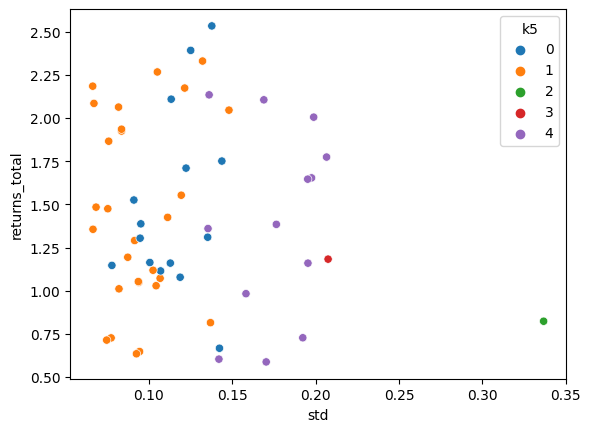

In [311]:
sns.scatterplot(data=data_agg,x="std",y="returns_total",hue="k5",palette="tab10")

Ce ratio reward-risk est au dessus de celui de l'indice, on effectue un K-Means sur les actifs et on obtient une discrimination selon l'écart-type (cf graphique au dessus). Pour diversifier, on décide de prendre un actif de chaque cluster (celui avec le ratio reward-risk) le plus élevé.

Pour la suite, on va construire un portefeuille entier en se basant sur un seul des clusters. Pour cela, on va prendre k=4 et garder le cluster avec l'écart-type le plus bas.

<AxesSubplot: xlabel='std', ylabel='returns_total'>

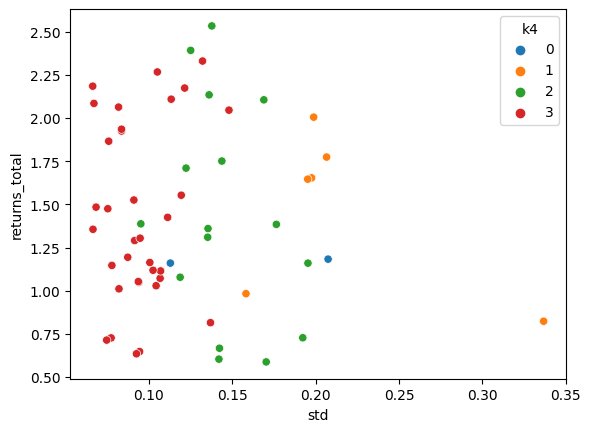

In [312]:
sns.scatterplot(data=data_agg,x="std",y="returns_total",hue="k4",palette="tab10")

In [318]:
sharpe_reward_risk_p3 = calcul_reward_risk_portfolio(returns_vf[returns_vf.index.isin(data_agg.loc[data_agg["k4"] == 3].index)].iloc[:,1:])
print(sharpe_reward_risk_p3)

22.9755760270354


Cette méthode permet d'obtenir un ratio reward-risk plus élevé car contrairement à la sélection partielle par cluster, on sélectionne le custer le moins risqué ce qui fait augmenter le ratio.

Cette démarche de prendre en compte l'ensemble des données pour réaliser les portefeuilles nous permettent de prendre en considération le ratio maximal qu'on peut s'attendre à avoir. En effet, tout ratio au-dessus de celui dont on dispose de toutes les informations serait un ratio aberrant.

### Stratégies basées sur les données jusqu'à 2020 et comparaison reward-risk sur 2020 à 2022

#### Stratégie naïve : construction du portefeuille selon les ratios passés

Cette méthode est plus robuste sur la méthode scientifique. En effet, nous avons accès aux données jusqu'à 2020 et on construit un portefeuille selons les ratio reward risk jusqu'à cette période.

In [320]:
reward_risk_p4 = calcul_reward_risk_portfolio(returns_test[returns_test.index.isin(data_agg_train.loc[data_agg_train["reward_risk"] > reward_risk_index].index)].iloc[:,1:])
print(reward_risk_p4)

18.32332298754883


On obtient un ratio reward-risk supérieur à celui de l'indice de référence sur la période.

#### Stratégies clustering sur les données passées

De la même manière que précédement, on utilise un clustering sur les returns des données passées et on prend le meilleur actif en terme de reward-risk sur cette période "d'entraînement". Puis on calcule le ratio reward-risk avec les données entre 2020 et 2022 avec cette sélection d'actifs.

In [339]:
reward_risk_p2 = calcul_reward_risk_portfolio(returns_test.loc[data_agg_train.groupby(['k5'], sort=False)['reward_risk'].idxmax()])
print(reward_risk_p2)

15.166715699508552


<AxesSubplot: xlabel='std', ylabel='returns_total'>

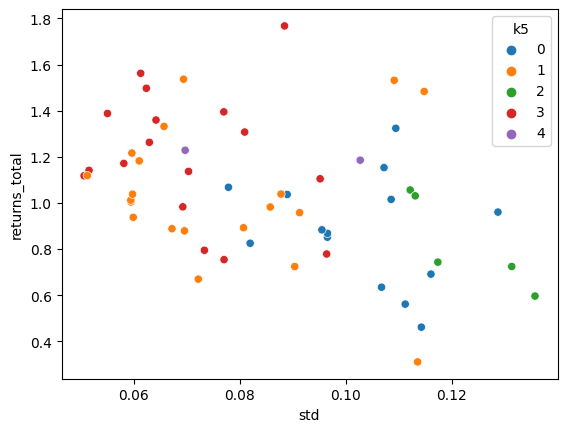

In [340]:
sns.scatterplot(data=data_agg_train,x="std",y="returns_total",hue="k5",palette="tab10")

Il est normal de ne pas différencier tout aussi bien les données puisque les valeurs correspondent aux returns cummulés sur la période de test et que les clusters ont été faits sur la période "d'entraînement". Nous voyons que nous obtenons également un reward risk plus élevé que celui de l'indice de référence sur la période de test. En revanche, ce dernier est moins élevé que l'approche naïve faite juste avant.

Comme précédemment, nous allons prendre un cluster entier d'un K-Means pour k=3.

<AxesSubplot: xlabel='std', ylabel='returns_total'>

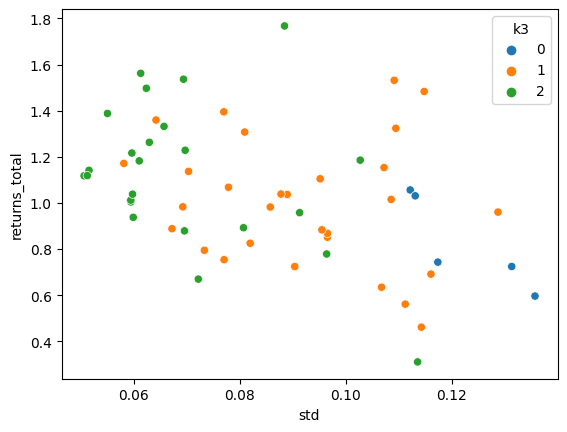

In [341]:
sns.scatterplot(data=data_agg_train,x="std",y="returns_total",hue="k3",palette="tab10")

In [343]:
sharpe_reward_risk_p3 = calcul_reward_risk_portfolio(returns_test[returns_test.index.isin(data_agg_train.loc[data_agg["k3"] == 2].index)].iloc[:,1:])
print(sharpe_reward_risk_p3)

11.802297324134818


En prenant un cluster entier (le moins risqué pendant la période d'entraînement), nous obtenons un reward-risk ratio quasiment égal à celui de l'indice pour la période de test.

### Conclusion

Finalement, nous avons vu qu'avec une démarche scientifique (deuxième partie) nous sommes en mesure de battre le reward-risk de l'indice de référence sur la période test. Cependant, nous pouvons voir que l'approche naïve de construction de portefeuille, qui consiste à prendre les actifs dont le reward risk sur la période d'entraînement est le plus élevé, est la meilleure des trois implémentations, ce qui laisse penser qu'on pourrait trouver des améliorations sur la manière dont le clustering est réalisé. Peut-être pouvons nous envisager un modèle de Gaussian Mixture pour corriger cela.

De plus, la période de référence est étalée sur 2 ans, ce qui rend les comparaisons pas réellement robuste. Pour améliorer la robustesse du modèle, nous pourrions envisager d'y ajouter des données anciennes afin que la période de test soit de l'ordre de 5 ans pour prendre en compte les grandes tendances plus que les plus petites.